In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, datasets
from pandas import DataFrame as df
from IPython.display import clear_output

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.core import  Activation, Dropout  
from keras.optimizers import RMSprop
from keras.layers import Embedding, RepeatVector
from keras.layers import LSTM
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import train_test_split


%matplotlib inline
#%matplotlib qt
%config InlineBackend.figure_format = 'retina'

Using Theano backend.
/Users/mac/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def import_data():
    dataset = pd.read_csv('../data/DP.csv',usecols=[27],engine='python',skipfooter=None)
    return dataset
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def prepareInputs(daydata, season, UsedInputs,testPeriod):
    nbrInputs= 0
    
    previousHours = UsedInputs[0]
    previousDay = UsedInputs[1]
    averageLoad = UsedInputs[2]
    maxLoad = UsedInputs[3]
    minLoad = UsedInputs[4]
    tempAverage = UsedInputs[5]
    tempMax = UsedInputs[6]
    tempMin = UsedInputs[7]
    dayIndicator = UsedInputs[8]
    monthIndicator = UsedInputs[9]
    
    if previousHours == True: nbrInputs = nbrInputs + 24
    if previousDay == True: nbrInputs= nbrInputs + 24
    if averageLoad == True : nbrInputs= nbrInputs + 1
    if maxLoad == True : nbrInputs= nbrInputs + 1
    if minLoad == True : nbrInputs= nbrInputs + 1
    if tempAverage == True: nbrInputs= nbrInputs + 1
    if tempMax == True: nbrInputs= nbrInputs + 1
    if tempMin == True: nbrInputs= nbrInputs + 1
    if dayIndicator== True: nbrInputs= nbrInputs + 7
    if monthIndicator== True : nbrInputs= nbrInputs + 12

        
    dayClusters= np.empty([daydata.index.size , 1])
    for x in range(0,daydata.index.size):
        dayClusters[x , 0] = daydata.iloc[x , 24]
        
    daydataindex= pd.DataFrame(index=pd.date_range('2014-1-8 00:00:00', periods=365, freq='D'))


    tempAlgiers=  pd.read_csv('../data/tempAlgiers.csv')
    tempA= tempAlgiers.loc[:,'Hour_1':'Hour_24']
    tempnp= np.array(tempA)
    tempdata= pd.DataFrame(tempnp)


    tempmax= tempAlgiers.loc[:,'Tmax']
    tempmin= tempAlgiers.loc[:,'Tmin']
    tempav= tempdata.transpose().mean()
    
    tempmx= np.random.random([tempmax.size,1])
    tempmn= np.random.random([tempmin.size,1])    
    
    samples = daydata.index.size
#     del(daydata2['cluster'])

    data= pd.DataFrame(np.array(daydata))

    maxcons= data.values.max()
    mincons= data.values.min()

    maxtemp= np.max(tempdata.values)
    mintemp= tempdata.values.min()

    maxtempmax= np.max(tempmx)
    mintempmax= np.min(tempmx)

    maxtempmin= np.max(tempmn)
    mintempmin= np.min(tempmn)
    
    maxtempav= np.max(tempav)
    mintempav= np.min(tempav)

    sigxx= np.empty((samples - 2 , nbrInputs))
    sigyy= np.empty((samples - 2 , 5))

    i= 0
    for x in list(range(2,samples)):
        i=0
        if previousHours == True: 
            for y in list(range(24)):
                sigxx[x - 2 , y] = (data.iloc[x -1, y])
                i = i + 1
        if previousDay == True: 
            for y in list(range(24)):
                sigxx[x - 2 , i + y] = (data.iloc[x - 2 , y])
                i = i + 1
        if averageLoad == True : 
            sigxx[x - 2 , i] = (data.iloc[x - 1, 0:24].mean())
            i= i + 1
        if maxLoad == True : 
            sigxx[x - 2 , i] = (data.iloc[x - 1, 0:24].max())
            i= i + 1
        if minLoad == True : 
            sigxx[x - 2 , i] = (data.iloc[x - 1, 0:24].min())
            i= i + 1
        if tempAverage == True: 
            sigxx[x - 2, i] = (tempav[x]) / (2 * maxtempav)
            i= i + 1
        if tempMax == True: 
            sigxx[x - 2, i] = (tempmx[x]) / (2 * maxtempmax)
            i= i + 1
        if tempMin == True: 
            sigxx[x - 2, i] = (tempmn[x]) / (2 * maxtempmin)
            i= i + 1
        if dayIndicator == True:
            ind=0
            for y in range(0,7):
                sigxx[x - 2, i + ind] = 0
                ind = ind + 1
            sigxx[x - 2 , i + pd.datetime.weekday(daydataindex.index[x])] = 1
            i = i + 7
        if monthIndicator == True:
            ind=0
            for y in range(0,12):
                sigxx[x - 2 , i + ind] = 0
                ind = ind + 1
            sigxx[x - 2 , i + daydataindex.index[x].month - 1]=1
            i = i + 12

    for x in list(range(2,samples)):
        ind = 0
        for y in range(0,5):
            sigyy[x - 2 , ind] = 0
            ind = ind + 1
        sigyy[x - 2 , int(data.iloc[x , 24])] = 1


    sigmoidxx= df(sigxx.copy())
    sigmoidyy= df(sigyy.copy())

    sigmoidxx.index= pd.date_range('2014-1-3 00:00:00', periods=(365-2), freq='D')
    sigmoidyy.index= pd.date_range('2014-1-3 00:00:00', periods=(365-2), freq='D')

    sigmoidxx['cluster'] = dayClusters[2:]
    sigmoidyy['cluster'] = dayClusters[2:]
    dfdayClusters = df(dayClusters)

    sigmoidxx = sigmoidxx[sigmoidxx.cluster<3]
#     df.drop(sigmoidxx[sigmoidxx.cluster<4])
    sigmoidyy= sigmoidyy[sigmoidyy.cluster<3]
#     df.drop(sigmoidyy[sigmoidyy.cluster==4])
    
    del(sigmoidxx['cluster'],sigmoidyy['cluster'])


    del sigmoidyy[3]
    del sigmoidyy[4]
#     SigmoidInputs =sigmoidxx[sigmoidxx.cluster==season].copy()

#     SigmoidOutputs= sigmoidyy[sigmoidyy.cluster==SigmoidInputs.loc[SigmoidInputs.index[0],'cluster']]
#     del(SigmoidInputs['cluster'],SigmoidOutputs['cluster'])
#     learningoutputs = pd.DataFrame(SigmoidOutputs.iloc[:int(SigmoidOutputs.size - testPeriod)].values.copy(),
#                             index=SigmoidOutputs.iloc[:int(SigmoidOutputs.size - testPeriod)].index)
#     testoutputs = pd.DataFrame(SigmoidOutputs.iloc[int(SigmoidOutputs.size - testPeriod):].values.copy(),
#                             index=SigmoidOutputs.iloc[int(SigmoidOutputs.size - testPeriod):].index)

#     learninginputs = pd.DataFrame(SigmoidInputs.iloc[:int(SigmoidOutputs.size - testPeriod)].values.copy(),
#                             index=SigmoidOutputs.iloc[:int(SigmoidOutputs.size - testPeriod)].index)
#     testinputs = pd.DataFrame(SigmoidInputs.iloc[int(SigmoidOutputs.size - testPeriod):].values.copy(),
#                             index=SigmoidOutputs.iloc[int(SigmoidOutputs.size - testPeriod):].index)
    
    
    
    
    print('-------Input preparation process complet-------')
#     return learninginputs, learningoutputs, testinputs, testoutputs, nbrInputs
    return sigmoidxx, sigmoidyy, nbrInputs

7
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  4.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  4.  4.  4.  1.  1.  4.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2. 

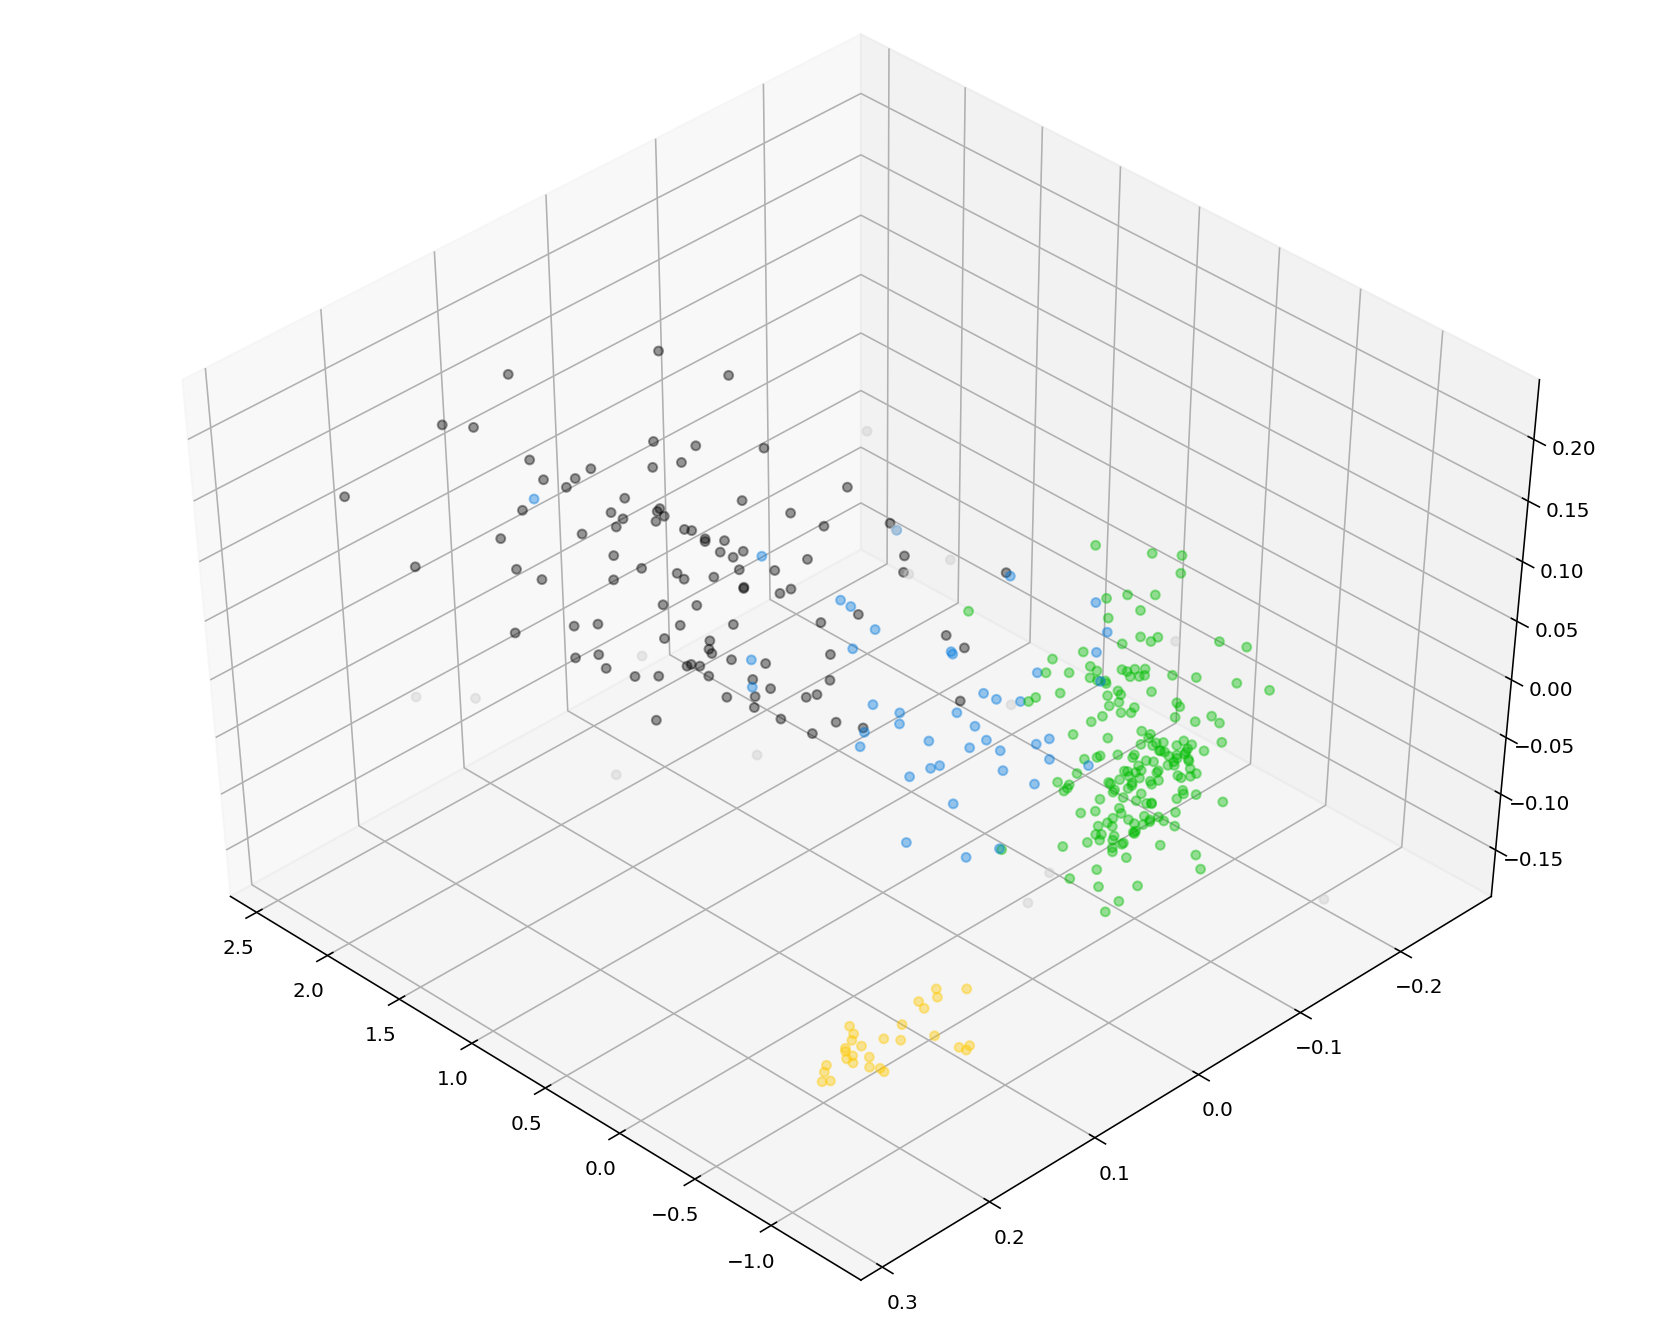

In [4]:
data = import_data()
data= np.array(data)


scaler= MinMaxScaler(feature_range=(0,1))


data = scaler.fit_transform(data)
data= data.reshape(-1,24)



daydata= df(data)
daydata.index= pd.date_range('2014-1-1', periods=365, freq='D')
print daydata.index[200].month


clusters= np.loadtxt('../data/Mixed_4_Clusters',delimiter=',')

pca= PCA(n_components=3)
pca.fit(daydata)
data_pca =  pca.transform(daydata)

# pdClusters= pd.DataFrame(clusters,index=daydata.index)


print(clusters)



fig = plt.figure(1, figsize=(12, 9))

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=45, azim=135)

dayofweek = pd.DatetimeIndex(daydata.index).dayofweek

ax.scatter(data_pca[:,0],data_pca[:,1],data_pca[:,2],cmap=plt.cm.spectral,c=clusters,alpha= 0.4)

plt.show()


daydata['cluster']=clusters



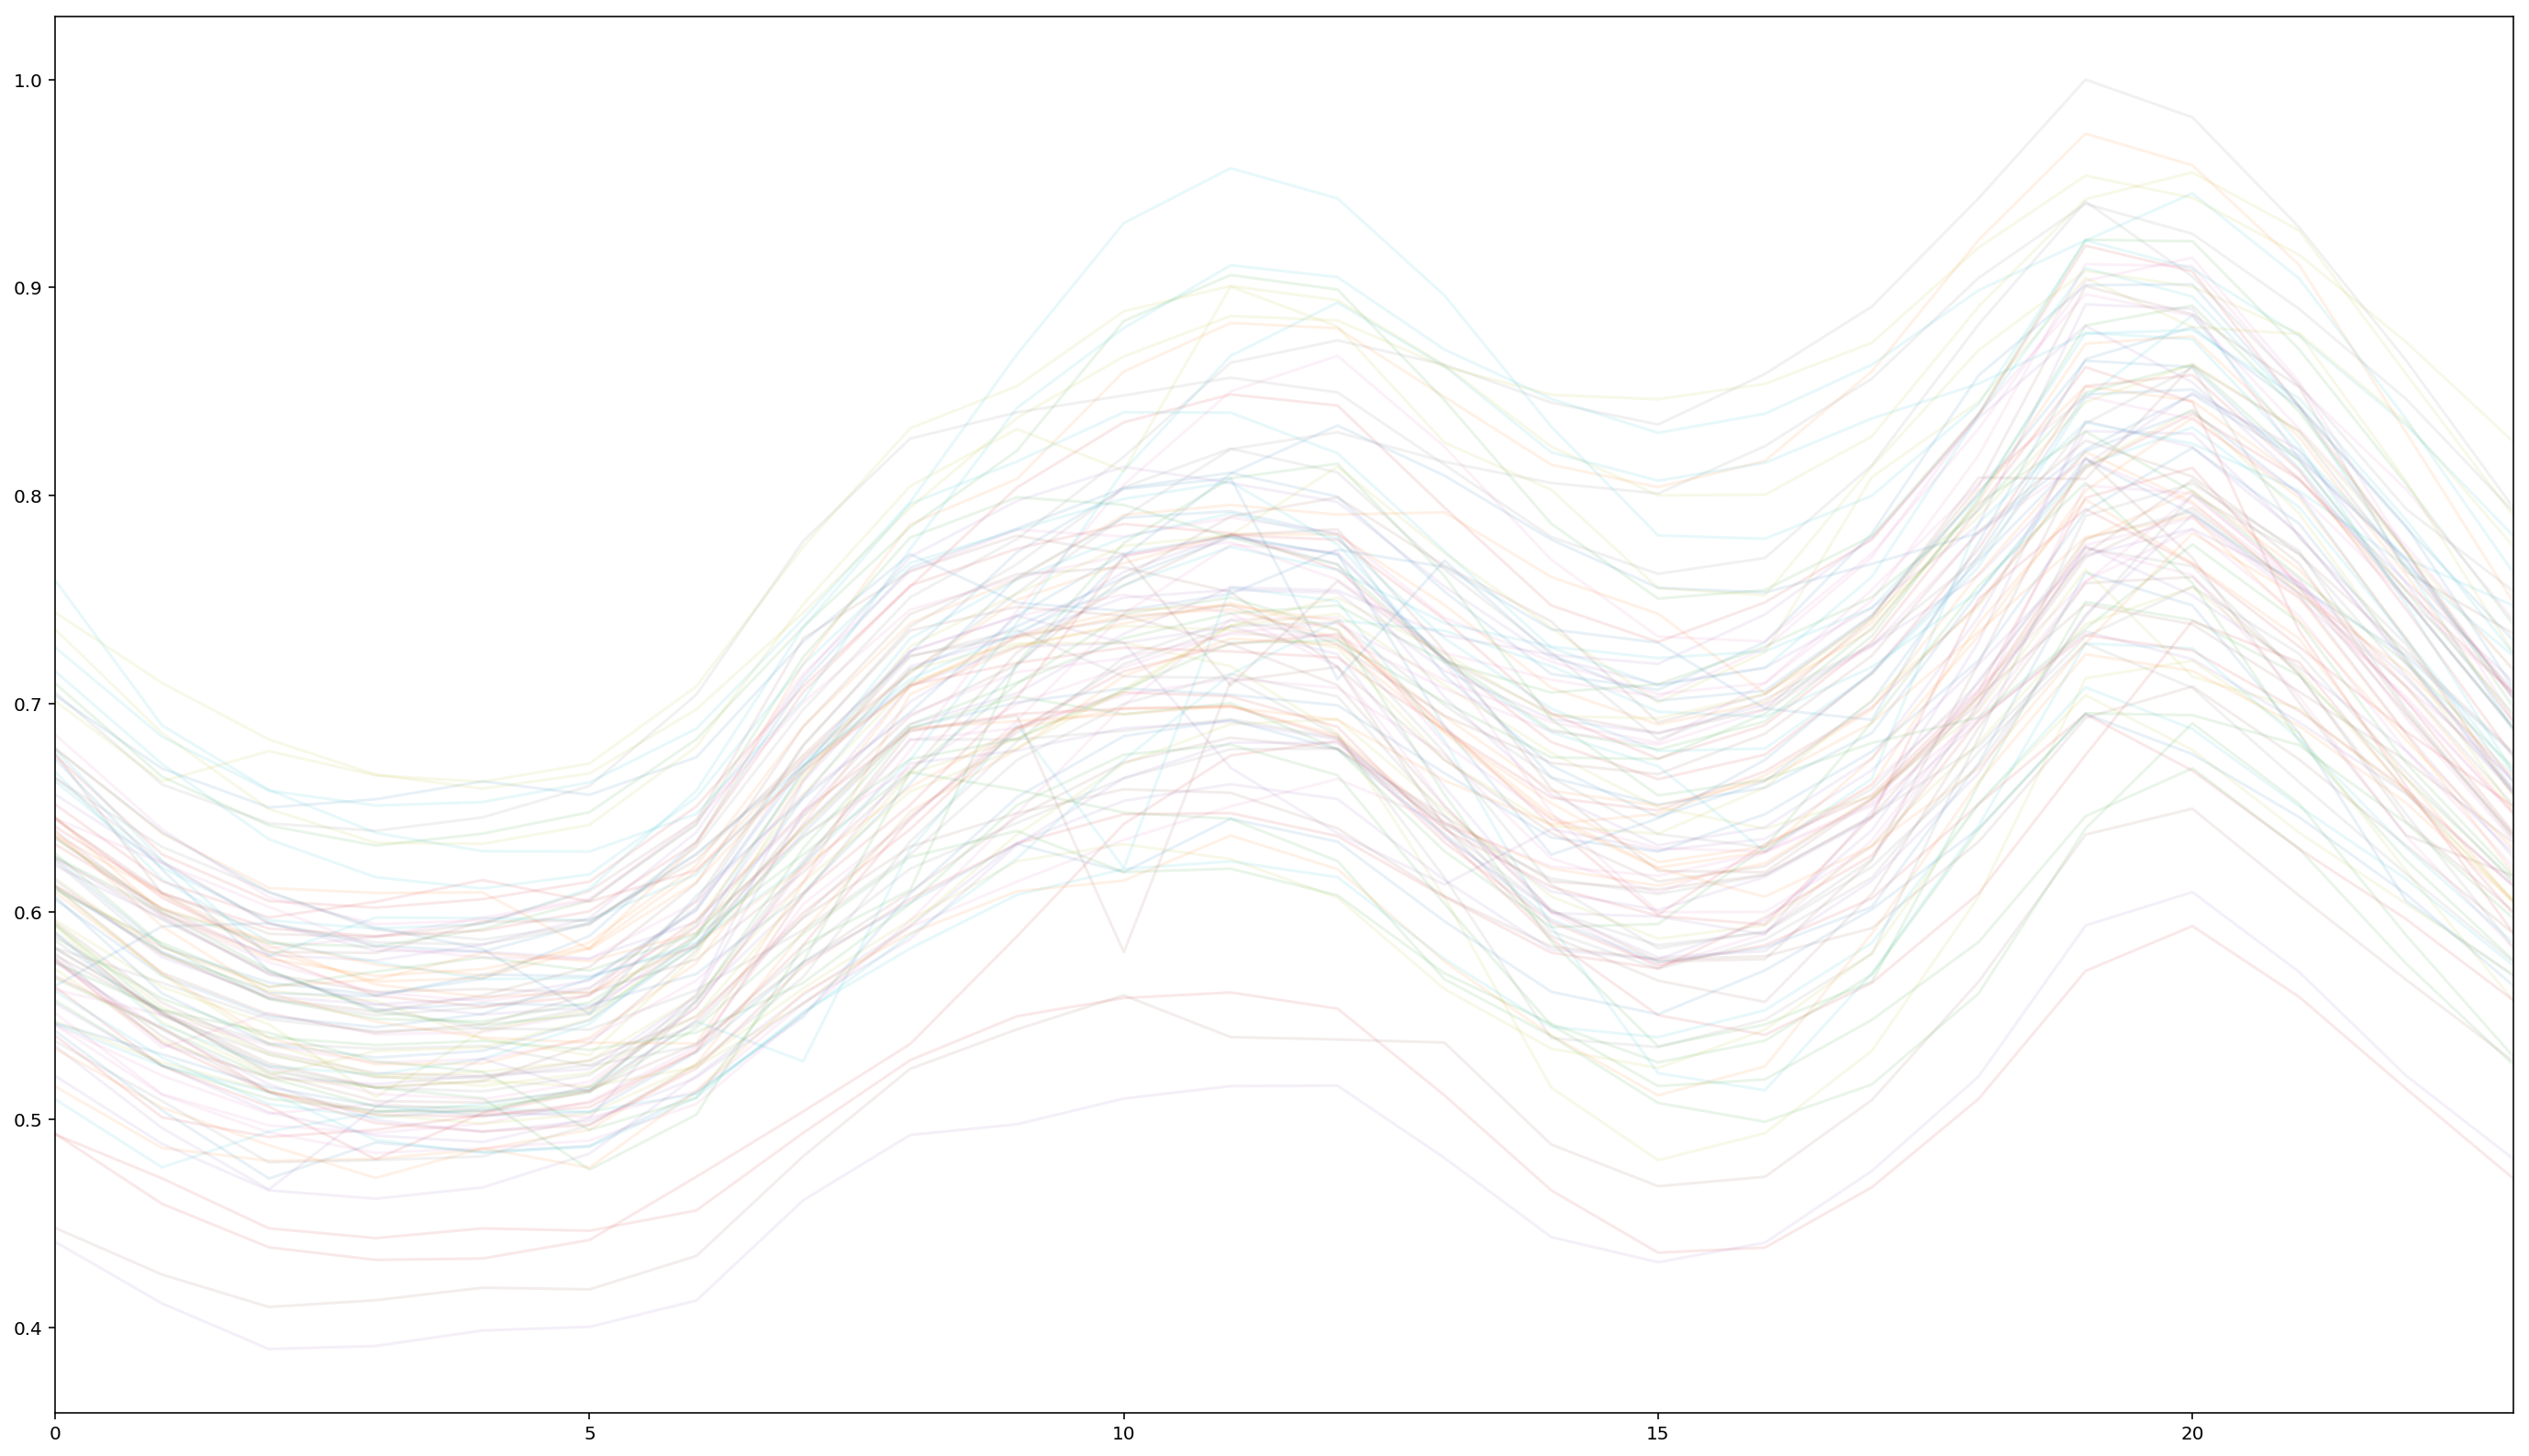

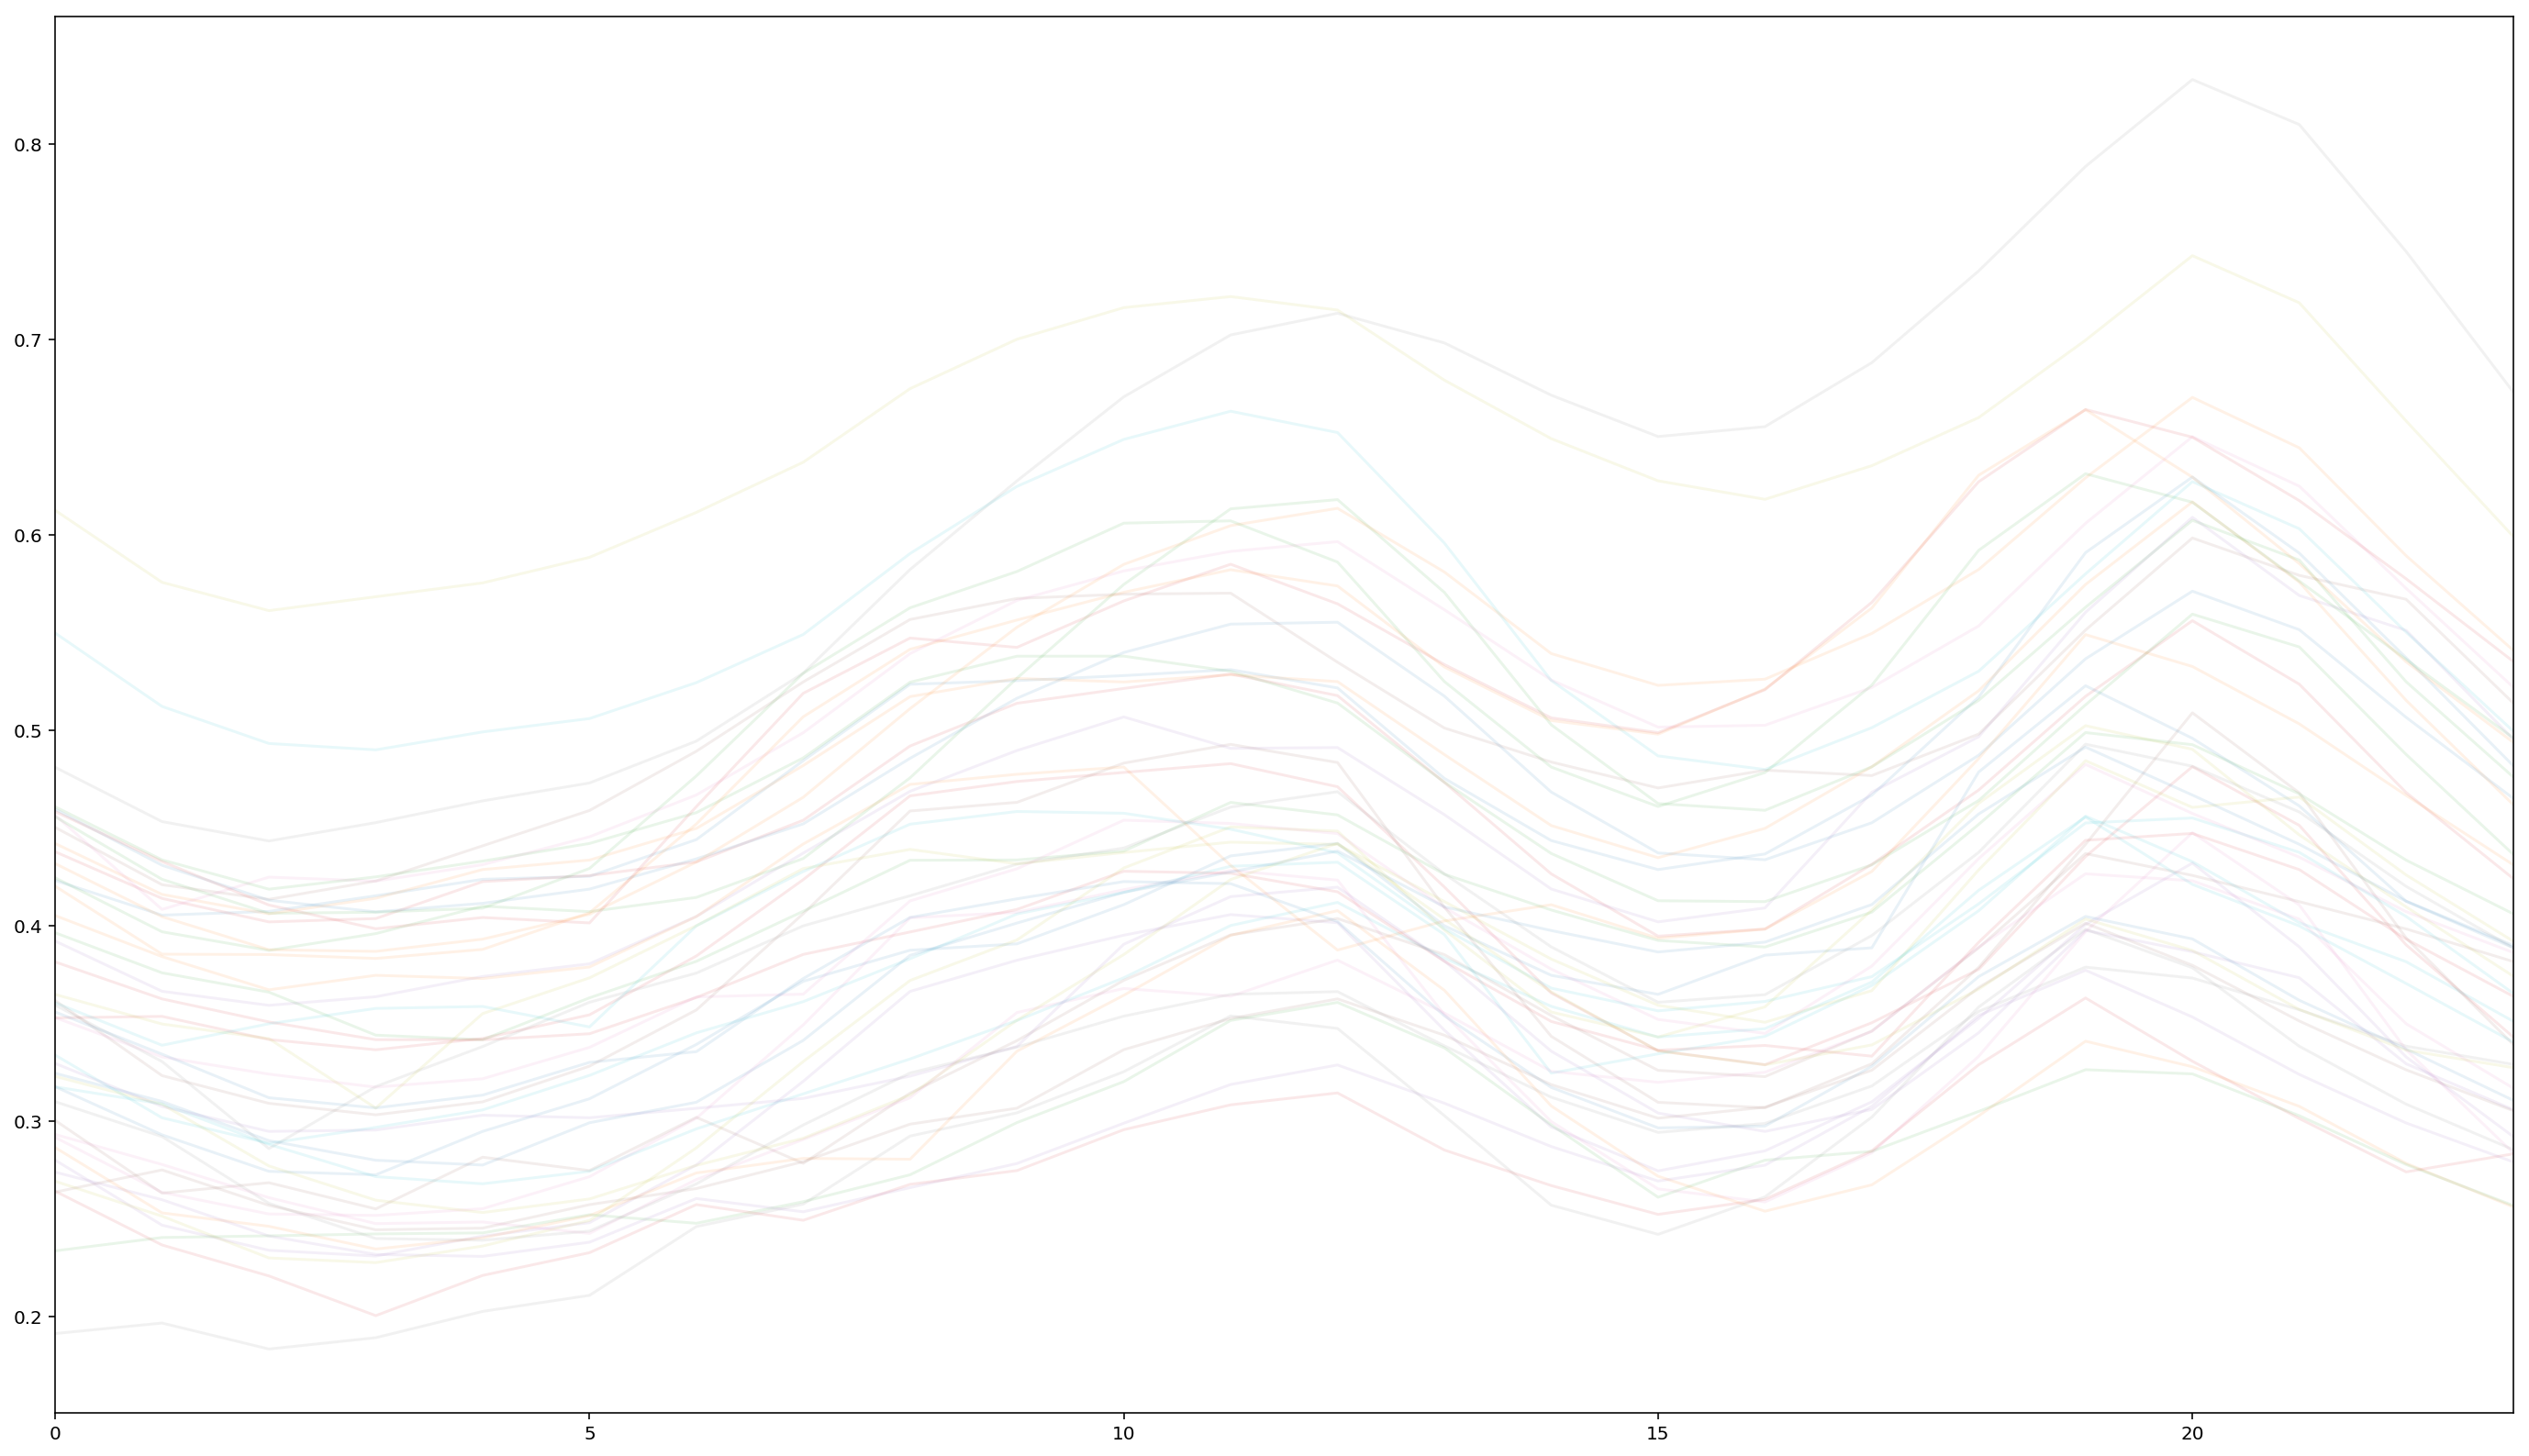

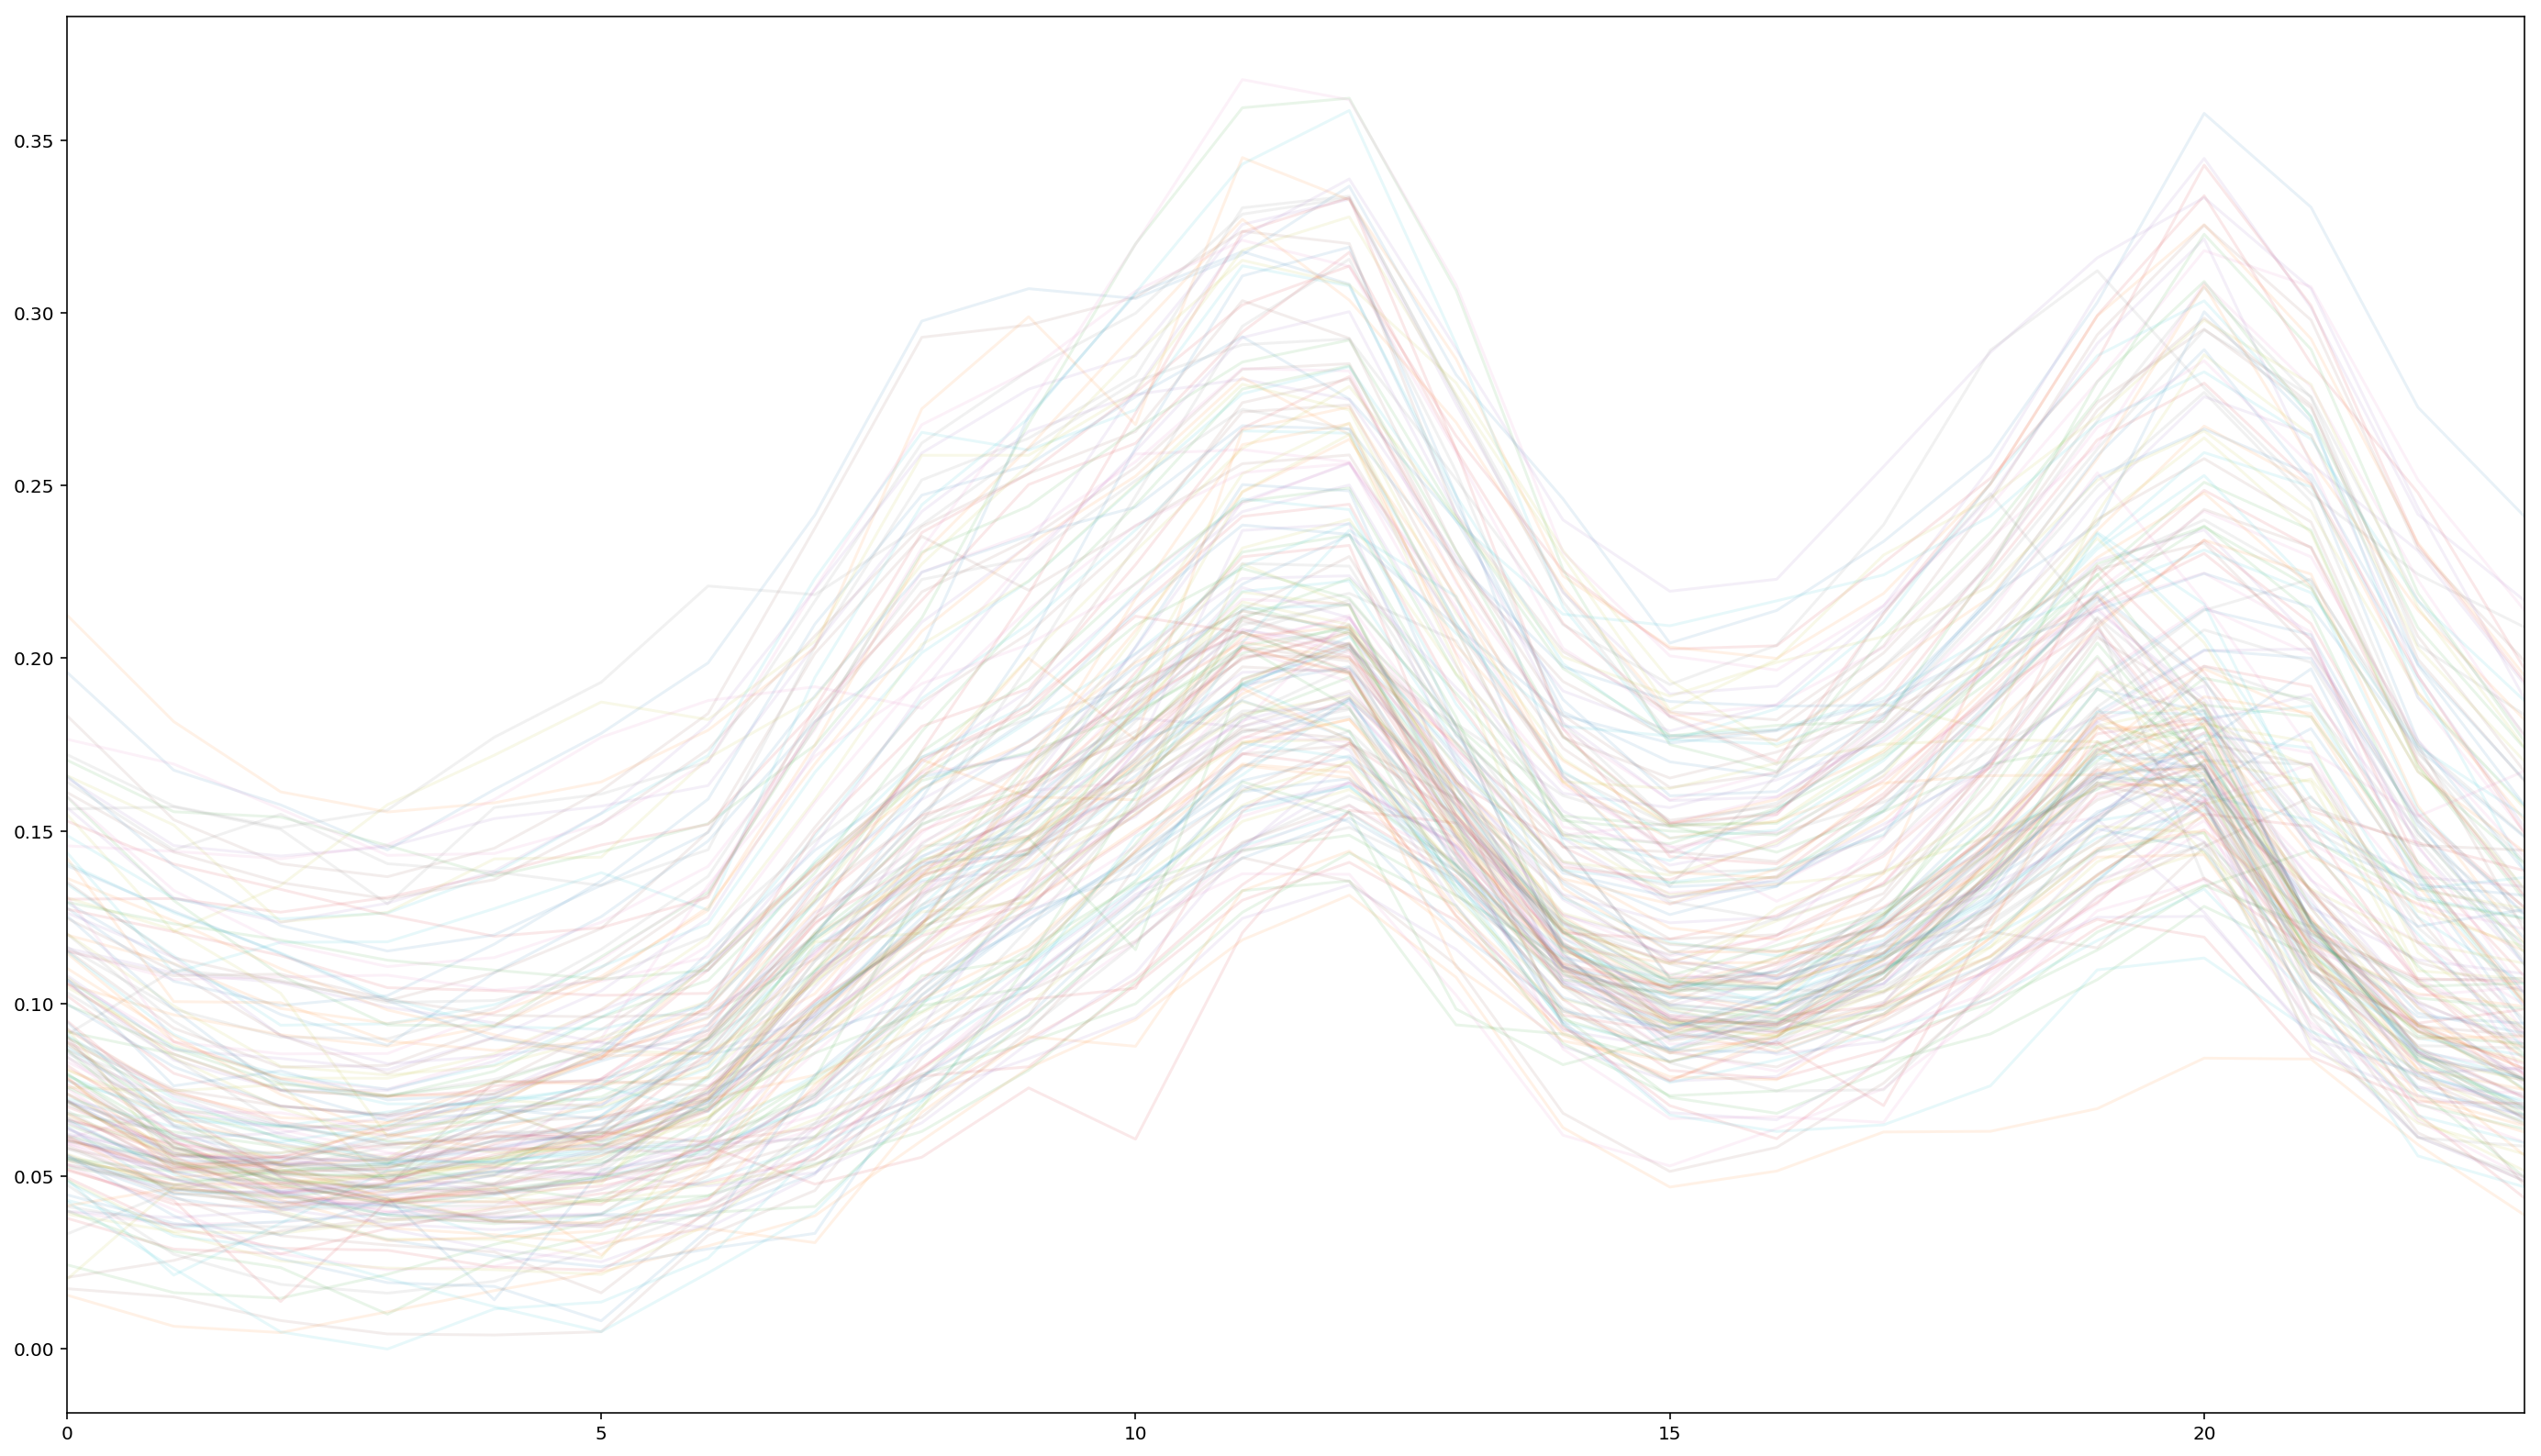

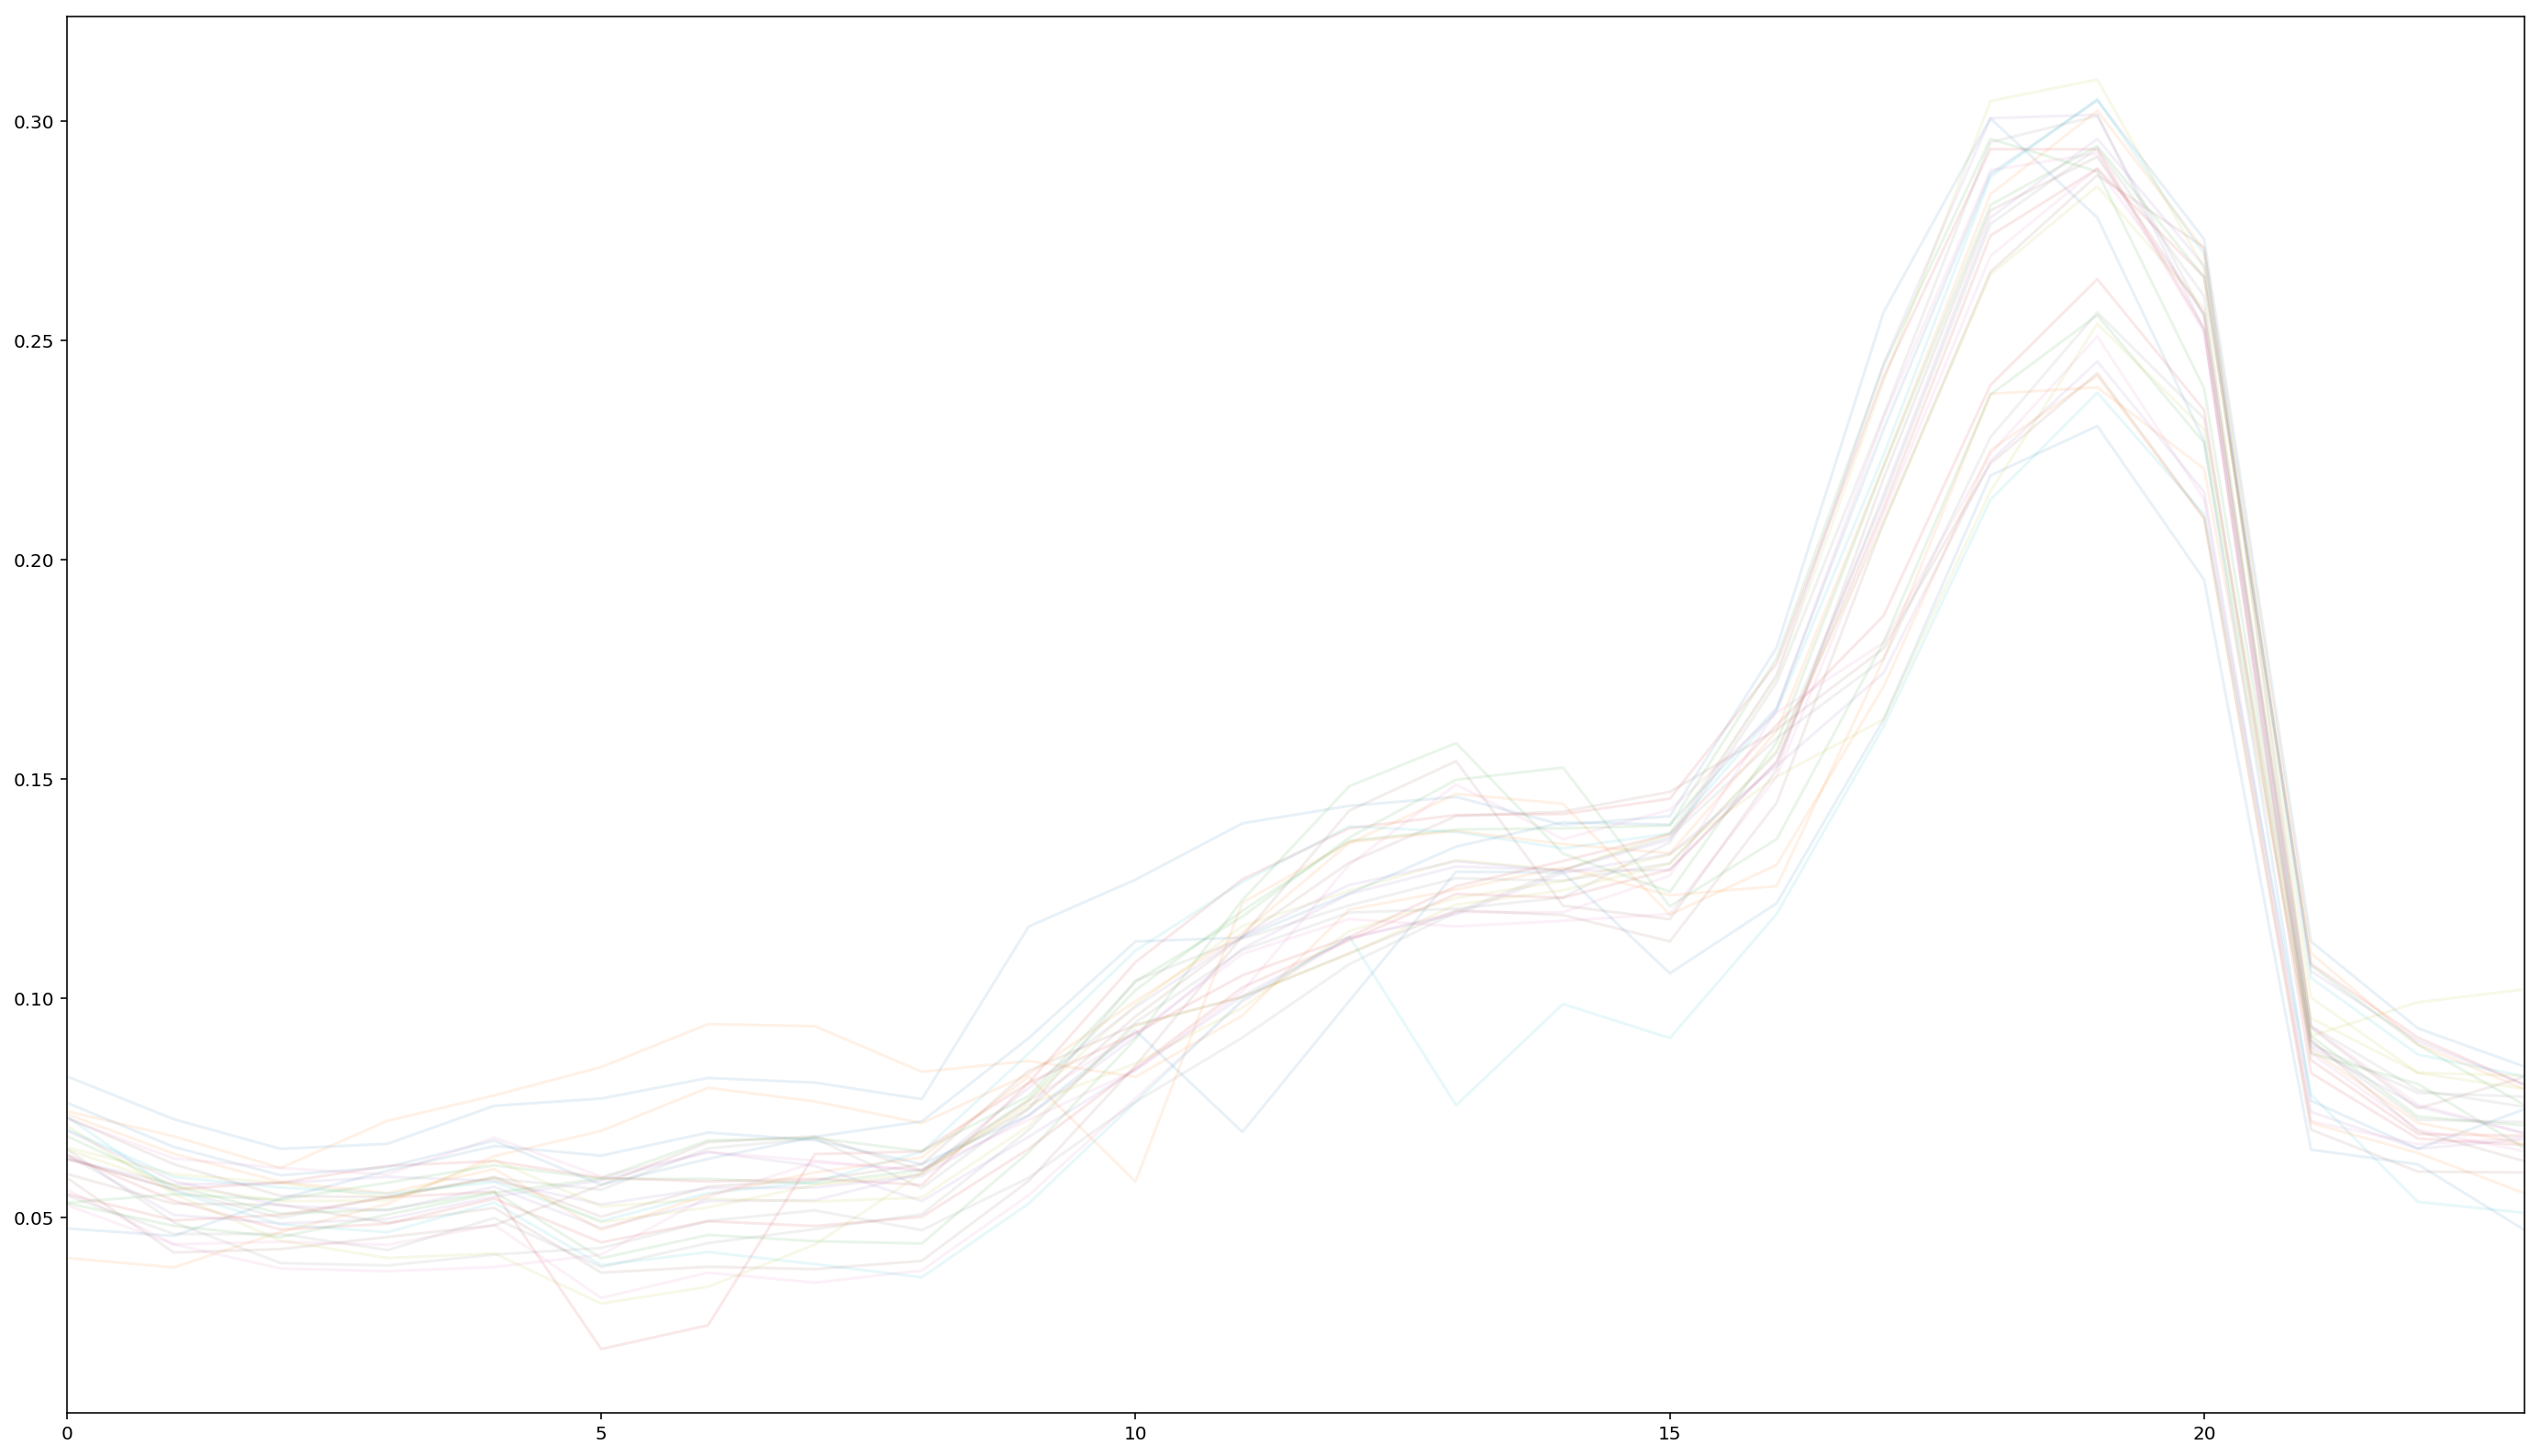

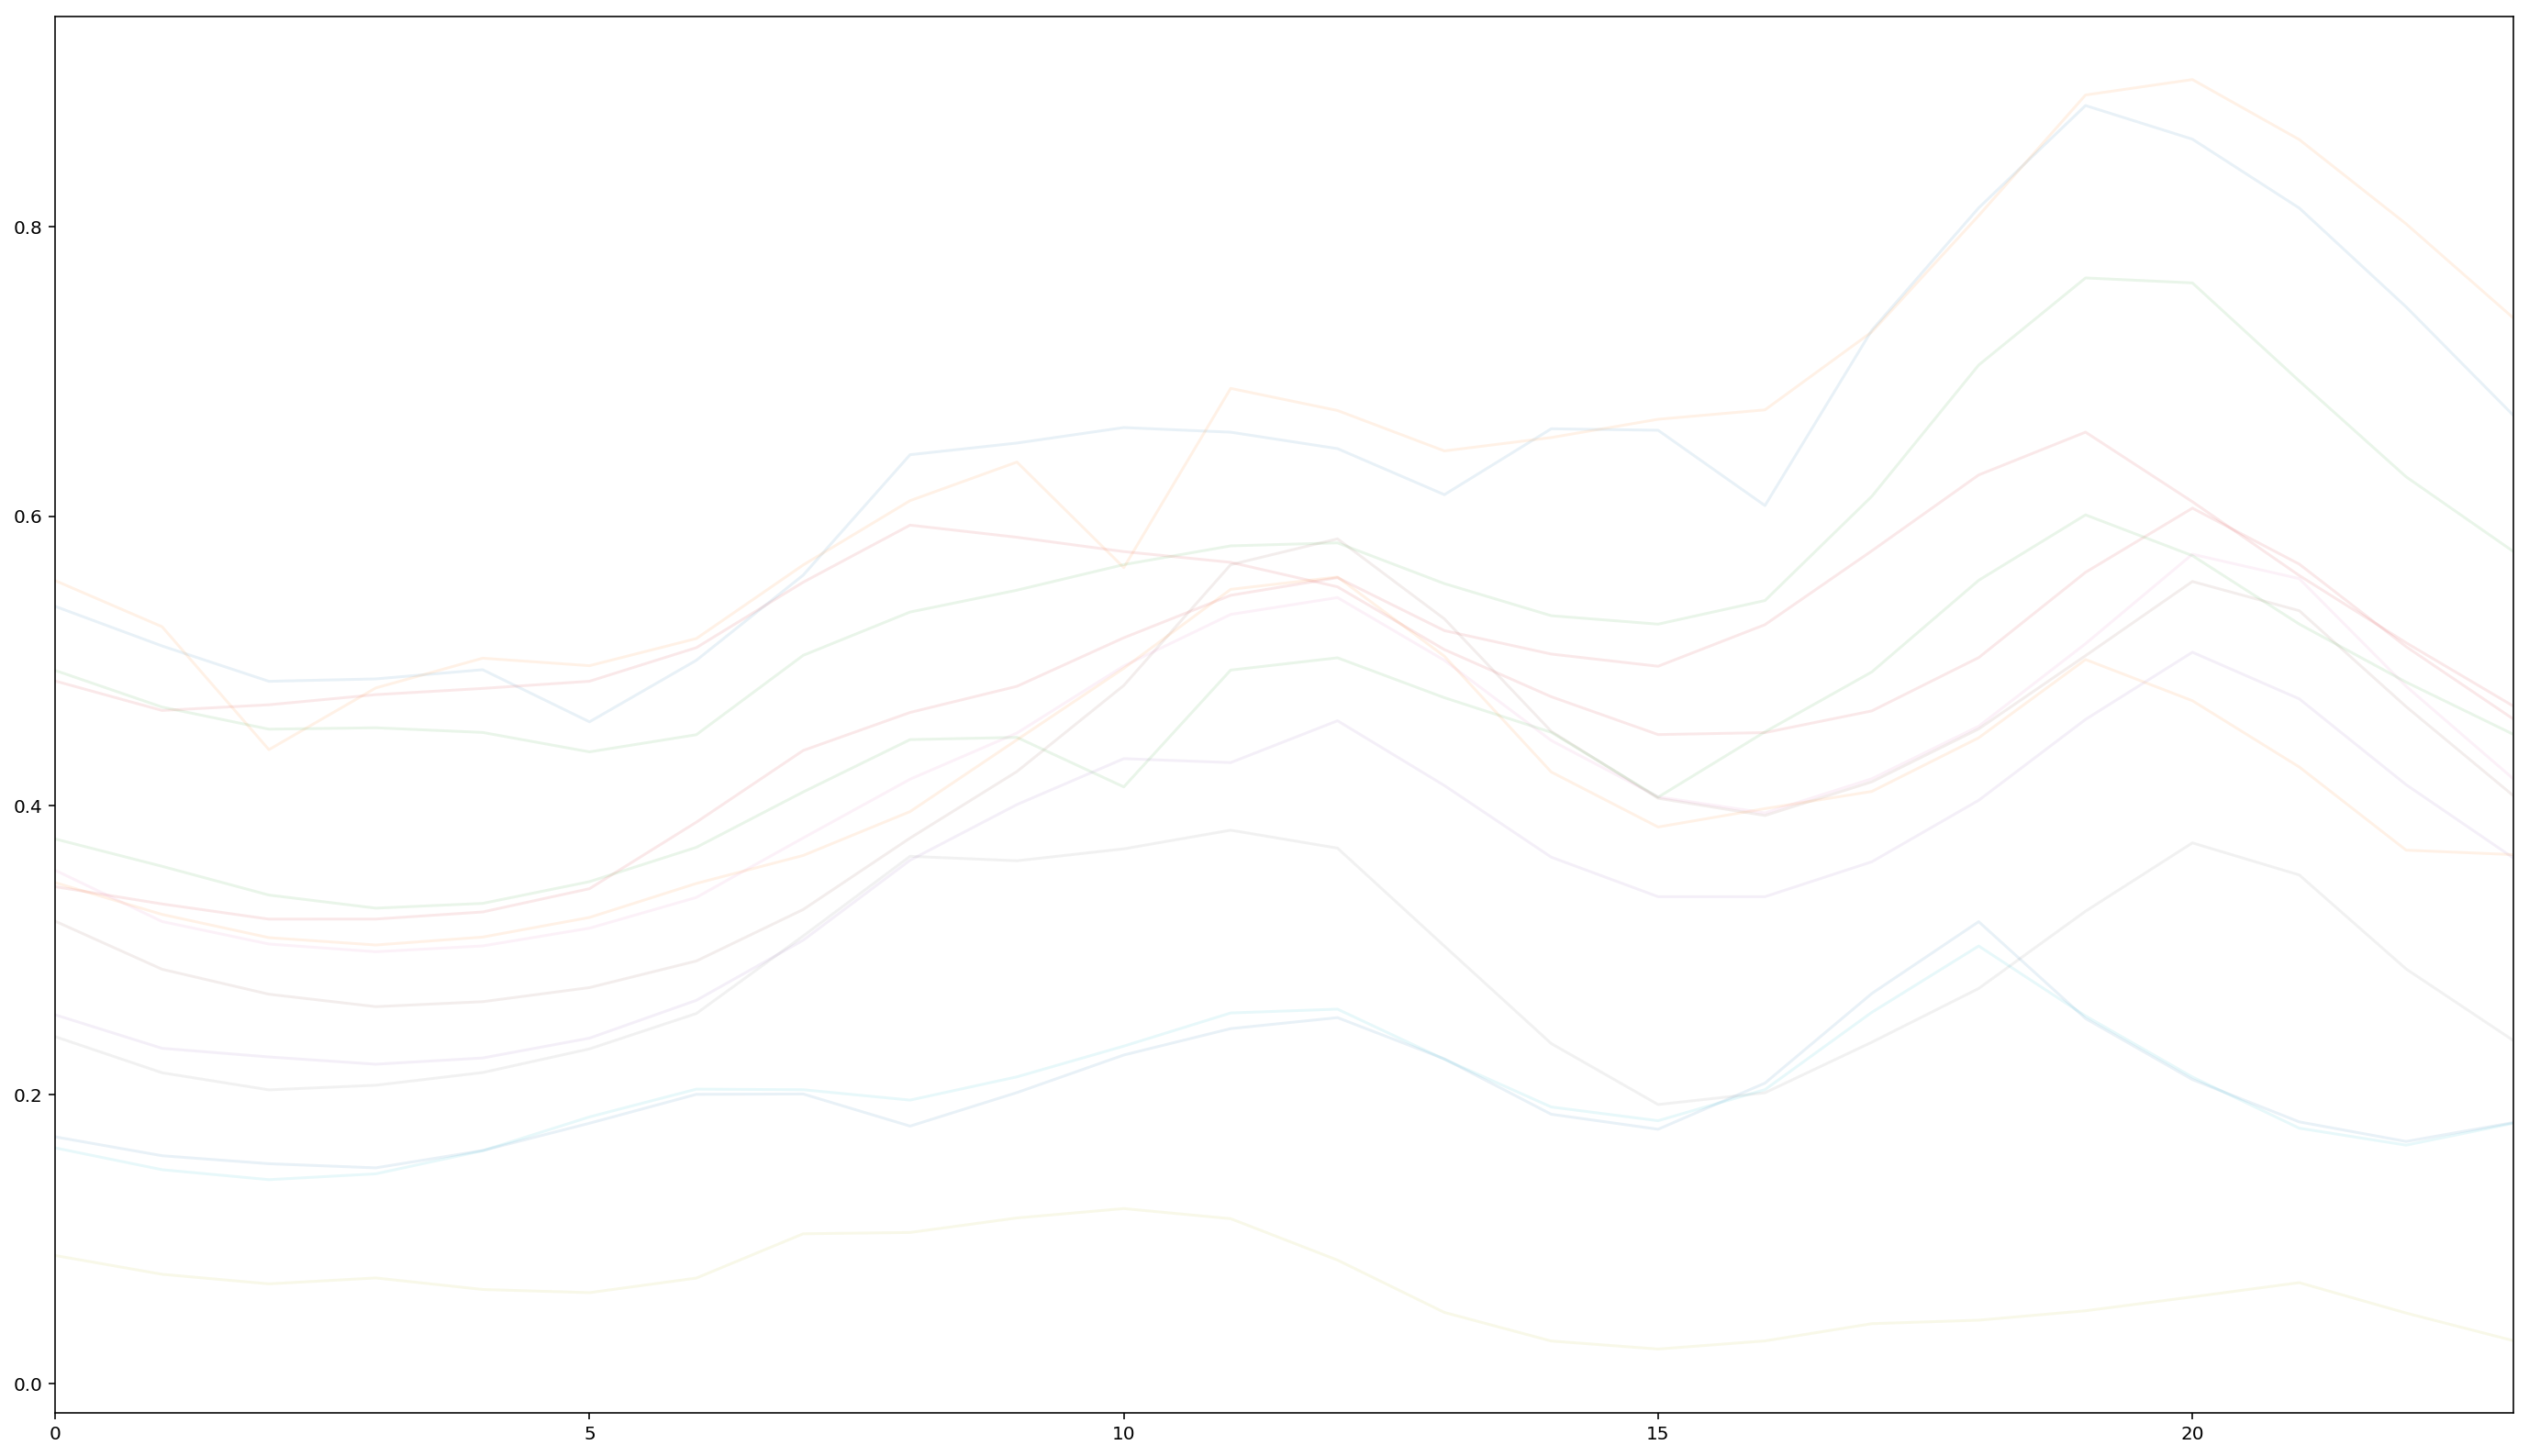

In [5]:
temp=daydata.copy()
del(temp['cluster'])

plt.figsize=(24,14)
temp[daydata.cluster==0].transpose().plot( alpha=0.1,figsize=(24,14),legend=None)

temp[daydata.cluster==1].transpose().plot( alpha=0.1,figsize=(24,14),legend=None)

temp[daydata.cluster==2].transpose().plot( alpha=0.1,figsize=(24,14),legend=None)

temp[daydata.cluster==3].transpose().plot( alpha=0.1,figsize=(24,14),legend=None)

temp[daydata.cluster==4].transpose().plot( alpha=0.1,figsize=(24,14),legend=None)


plt.show()

In [6]:
def create_Train_MLP_NN_Model(inputx1,outputx1,inputx2,outputx2,n_features,HiddenNeurons1=None,HiddenNeurons2=None
                              ,LearningRate=None,Epoch=None,Optimizer=None, timeSteps= None):
    
    if HiddenNeurons1 is None: HiddenNeurons1 = 10
    if HiddenNeurons2 is None: HiddenNeurons2 = 5
    if LearningRate is None: LearningRate = 0.001
    if Epoch is None: Epoch = 500
    if Optimizer is None: Opitimizer = 'Adam'
    if timeSteps is None: timeSteps = 1
    
    mlpmodel = Sequential()
    # Dense(64) is a fully-connected layer with 64 hidden units.
    # in the first layer, you must specify the expected input data shape:
    # here, 20-dimensional vectors.
#     mlpmodel.add(LSTM(units= HiddenNeurons1, return_sequences=True, activation='sigmoid', input_shape=(timeSteps, n_features)))  # returns a sequence of vectors of dimension 32
#     mlpmodel.add(LSTM(units= HiddenNeurons2, activation='sigmoid', return_sequences=False))  # returns a sequence of vectors of dimension 32
#     mlpmodel.add(Dense(5, init='uniform',activation='sigmoid'))
#     mlpmodel.compile(optimizer=Optimizer, loss='mse')
    mlpmodel.add(Dense(HiddenNeurons1, input_dim=inputx1.shape[1],activation='sigmoid'))
    mlpmodel.add(Dense(HiddenNeurons2, init='uniform'))
    mlpmodel.add(Dense(3, init='uniform'))
    mlpmodel.add(Activation('sigmoid'))

    sgd = SGD(lr=LearningRate, decay=1e-6, momentum=0.9, nesterov=True)
    mlpmodel.compile(loss='mse', optimizer=Optimizer)
    mlpmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    tempMLPmodels= np.empty((Epoch),dtype=object)
    tempErrorHistory= np.empty((Epoch),dtype=object)

    counter=0
    for i in range(0,Epoch):
        print('epoch:   %d .' %counter)
        ErrorHistory= mlpmodel.fit(x=inputx1.reshape(-1,n_features), y=outputx1, epochs=1,batch_size=12
                                   ,validation_data=(inputx2.reshape(-1,n_features),outputx2),verbose= 2)
        tempMLPmodels[i]= mlpmodel
        print ErrorHistory.history
        mlpmodel.save('Models/lstm_%d_%s'%(i,season))
        tempErrorHistory[i]=ErrorHistory.history['loss']
        counter = counter +1    
    print('==============================================================================')
    print('\t \t MLP model is ready for profile estimation')
    print('==============================================================================')
    
    
    return tempMLPmodels, tempErrorHistory, mlpmodel

def getForecastingResults(tempMLPmodels, tempErrorHistory, learninginputs, learningoutputs, testinputs, testoutputs, Model, nbrInputs, IsShift, previoushour, season, timeSteps):
        
    predictionPeriod = learninginputs.index.size
    temp=learninginputs.iloc[:predictionPeriod].resample('D').sum()
    temp= temp.dropna()
    temp2=learninginputs.iloc[:predictionPeriod]

    arg= tempErrorHistory.argmin()
    Model = load_model('Models/lstm_%d_%s'%(arg,season))
        
    LearningForecastingError=pd.DataFrame(np.random.randn((predictionPeriod)/24, 1))

    learningInputs= learninginputs.iloc[:learningoutputs.index.size].copy()
    learningOutputs= learningoutputs.iloc[:learningoutputs.index.size].copy()
    HlearningInputs= learninginputs.iloc[:learninginputs.index.size].copy()

    LearningDailyForecast=pd.DataFrame(np.random.randn(predictionPeriod, 3),index=temp2.index)
    LearningHourlyForecast=pd.DataFrame(np.random.randn(predictionPeriod, 2),index=temp2.index)
    

    print('==============================================================================')
    print('\t \t learning subset results')
    print('==============================================================================')

    for y in range(0,predictionPeriod/24):
        dailyError = 0

        for x in range(0,24):

            if IsShift == True:
                Hforecast=Model.predict(HlearningInputs.iloc[x + (y * 24) + 1].values.reshape(-1,1,nbrInputs))
                forecast=Model.predict(learningInputs.iloc[x + (y * 24) + 1].values.reshape(-1,1,nbrInputs))
            else :
                Hforecast=Model.predict(HlearningInputs.iloc[x + (y * 24)].values.reshape(-1,1,nbrInputs))
                forecast=Model.predict(learningInputs.iloc[x + (y * 24)].values.reshape(-1,1,nbrInputs))
                
            dailyError = dailyError + (np.abs(((learningOutputs.iloc[x + (y * 24),0] - forecast[0]) / 
                                              learningOutputs.iloc[x + (y * 24),0]))*100)
            
            LearningDailyForecast.iloc[x + (y * 24),0]= learningOutputs.iloc[x + (y * 24),0]
            LearningDailyForecast.iloc[x + (y * 24),1]= forecast
            LearningDailyForecast.iloc[x + (y * 24),2]= Hforecast
            
            LearningHourlyForecast.iloc[x + (y * 24),0]= learningOutputs.iloc[x + (y * 24),0]
            LearningHourlyForecast.iloc[x + (y * 24),1]= Hforecast

            
            if previoushour == True: 
                if IsShift == True: 
                    if x + 2 < 24: learningInputs.iloc[(x + (y * 24)) + 2,0] = forecast[0]
                else :
                     for z in range(0,timeSteps):
                        if x + z + 1 < 24: learningInputs.iloc[(x + (y * 24)) + 1 + z, z] = forecast[0]
        
        dailyError = (dailyError / 24)

        LearningForecastingError.iloc[y,0] = dailyError

    HlearningMAPE= mean_absolute_percentage_error(LearningHourlyForecast.iloc[:,1], LearningHourlyForecast.iloc[:,0])
    print('Hourly Learning mean absolute percentage error of %d hours : %s ' %(LearningHourlyForecast.shape[0] , HlearningMAPE))

    LearningMAPE = LearningForecastingError.mean()
    print('Daily Learning mean absolute percentage error of %d days : %s ' %(LearningHourlyForecast.shape[0]/24 ,LearningMAPE[0]))
    
    print('==================================================================================')
    print('\t \t MAPError plot through Learning DataSet ')
    print('==================================================================================')
    
    fig = plt.figure(figsize=(12,3))
    plt.plot(LearningForecastingError,label='Error')
    plt.show()
    
    dstart= testinputs.index[0]
    dstarti= 0
    dend= testinputs.index[testinputs.index.size-2]
    dendi= testinputs.shape[0]-2
    dend2= testinputs.index[testinputs.index.size-1]
    dend2i= testinputs.shape[0]-1
    
    
    forecasting_history=pd.DataFrame(np.random.randn(dendi, 2),columns=['real', 'forecast 24 steps'])
    Hforecasting_history=pd.DataFrame(np.random.randn(dendi, 2),columns=['real', 'forecast'])


    validationInputs= testinputs.iloc[dstarti:dend2i,:].copy()
    validationOutputs= testoutputs.iloc[dstarti:dendi,:].copy()
    
    HvalidationInputs= testinputs.iloc[dstarti:dend2i,:].copy()

    for x in range(dstarti,dendi):
        if IsShift == True:
            forecast=Model.predict(validationInputs.iloc[x + 1].values.reshape(-1,1,nbrInputs))
            Hforecast=Model.predict(HvalidationInputs.iloc[x + 1].values.reshape(-1,nbrInputs))
        else :
            forecast=Model.predict(validationInputs.iloc[x + 0].values.reshape(-1,1,nbrInputs))
            Hforecast=Model.predict(HvalidationInputs.iloc[x + 0].values.reshape(-1,1,nbrInputs))
        
        forecasting_history.iloc[x,0]= testoutputs.iloc[x,0]
        forecasting_history.iloc[x,1]= forecast[0][0]
#         forecasting_history.iloc[x,2]= Hforecast[0][0]
        
        
        Hforecasting_history.iloc[x,0]= testoutputs.iloc[x,0]
        Hforecasting_history.iloc[x,1]= Hforecast[0][0]

        if previoushour == True: 
            if IsShift == True:
                if ((x + 2)) + 1 < testPeriod - 1: 
                    validationInputs.iloc[x + 2,0] = forecast[0]
            else :
                for z in range(0,timeSteps):
                    if ((x +1)) + z + 1 < testPeriod - 1: 
                        validationInputs.iloc[x + 1 + z , z] = forecast[0]

    
    HtestMAPE= mean_absolute_percentage_error(Hforecasting_history.iloc[:,1], Hforecasting_history.iloc[:,0])
    testMAPE= mean_absolute_percentage_error(forecasting_history.iloc[:,1], forecasting_history.iloc[:,0])
    
    print('==================================================================================')
    print('\t \t Test subset results')
    print('==================================================================================')


    print('Test mean absolute percentage error per hour: %f' %HtestMAPE)
    print('Test mean absolute percentage error per day: %f ' %testMAPE)


    print('==================================================================================')
    print('\t \t Validation Forecasting visualisation')
    print('==================================================================================')
    fig = plt.figure(figsize=(12,4))
    plt.plot(forecasting_history[:dendi], label=['real','forecast 24 steps'])
    plt.legend(labels=['real','forecast 24 steps'],loc= 'best')
    plt.show()
    
    return LearningMAPE, testMAPE, HlearningMAPE, LearningDailyForecast, LearningHourlyForecast

def compare_classes(A_classes, P_classes):
    accurate_classes = 0
    wrong_classes = 0 
    for x in range(np.size( P_classes)):
        if P_classes[x] == A_classes[x]: accurate_classes = accurate_classes + 1
        else : wrong_classes = wrong_classes + 1
    return accurate_classes, wrong_classes

def class_from_labels(outputs):
#     classes = np.empty(shape=[outputs.shape[0],1])
    classes= []
    for x in range(outputs.shape[0]):
        for y in range (outputs.shape[1]):
            if outputs[x , y] == 1: classes.append(y)
    
    return classes


In [275]:
season = 0
Epoch = 3000

testPeriod = 360

UsedInputList = []
ModelsList = []
MAPErrorList = []
ForecastingList = []
Models_IDs = []
Models_parameters = []
Model_ID = 0

In [276]:
UsedInputsTemp= np.empty([10],dtype='bool')
FinalErrorTemp= np.empty([2])
Parameters = np.empty([4])
ID= np.empty([1])
ID[0]=Model_ID

UsedInputsTemp[0] = previoushour = True
UsedInputsTemp[1] = previousDay = True
UsedInputsTemp[2] = averageLoad = True
UsedInputsTemp[3] = maxLoad = True
UsedInputsTemp[4] = minLoad = True
UsedInputsTemp[5] = TempAverage = True
UsedInputsTemp[6] = TempMax = True
UsedInputsTemp[7] = TempMin = True
UsedInputsTemp[8] = dayIndicator = True
UsedInputsTemp[9] = monthIndicator = True

shift = False

learninginputs, learningoutputs, nbrInputs= prepareInputs(daydata,season,UsedInputsTemp,testPeriod)
#learning vectors
X_train, X_test, Y_train, Y_test = train_test_split(learninginputs, learningoutputs, test_size=0.33, random_state=7)


train_X = np.array(pd.DataFrame(X_train.copy())).reshape(-1,nbrInputs)
train_Y = np.array(pd.DataFrame(Y_train.copy()))

#test vectors
test_X = np.array(pd.DataFrame(X_test.copy())).reshape(-1,nbrInputs)
test_Y = np.array(pd.DataFrame(Y_test.copy()))

Parameters[0]= HiddenNeurons1 = 20
Parameters[1]= HiddenNeurons2 = 10
Parameters[2]= LearningRate = 0.001



# tempMLPmodels, tempErrorHistory,MLP_Model = create_Train_MLP_NN_Model(train_X,train_Y,test_X,test_Y,train_X.shape[1],HiddenNeurons1=HiddenNeurons1,HiddenNeurons2=HiddenNeurons2
#                                       ,Epoch=Epoch,LearningRate = LearningRate,Optimizer='rmsprop')

clear_output()

print('==================================================================================')
print('\t \t test num : %s' %Model_ID )
print('==================================================================================')

top_epoch = tempErrorHistory.argmin()
Parameters[3] = top_epoch
MLP_Model = load_model('Models/lstm_%d_%s'%(top_epoch,0))




print ('lowest error was recorded on the %d th epoch'%tempErrorHistory.argmin())

score = MLP_Model.evaluate(test_X, test_Y, batch_size=12,verbose=2)
print('Test score:', score)

train_P_classes = MLP_Model.predict_classes(train_X)
train_A_classes = class_from_labels(train_Y)

test_P_classes = MLP_Model.predict_classes(test_X)
test_A_classes = class_from_labels(test_Y)

train_accurate, train_wrong = compare_classes(train_A_classes, train_P_classes)

test_accurate, test_wrong = compare_classes(test_A_classes, test_P_classes)

print ('Training results: %d well classified and %d miss-classified daily profile' %(train_accurate, train_wrong))

print ('Test results: %d well classified and %d miss-classified daily profile' %(test_accurate, test_wrong))





# LearningMAPE, testMAPE , LearningHourlyMAPE, LearningDailyForecast, LearningHourlyForecast  = getForecastingResults(
#     tempMLPmodels, tempErrorHistory,learninginputs,learningoutputs,testinputs,testoutputs,MLP_Model,nbrInputs,shift,previoushour,season,timeSteps)
# FinalErrorTemp[0] = LearningMAPE
# FinalErrorTemp[1] = testMAPE

# UsedInputList.append(UsedInputsTemp)
# MAPErrorList.append(FinalErrorTemp)
# ModelsList.append(MLP_Model)
# ForecastingList.append(LearningDailyForecast)
# Models_IDs.append(ID)
# Models_parameters.append(Parameters)

# print('==================================================================================')
# print('\t \t Forecasting a sample from Learning dataset')
# print('==================================================================================')
# plt.figure(figsize=(12,4))
# ForecastingList[Model_ID].index= range(ForecastingList[Model_ID].index.size)
# plt.plot(ForecastingList[Model_ID].iloc[:,0],label='Forecast')
# plt.plot(ForecastingList[Model_ID].iloc[:,1],label='Real')
# plt.legend( loc=1, borderaxespad=0.4)
# plt.show()

# Model_ID = Model_ID + 1

	 	 test num : 0
lowest error was recorded on the 1417 th epoch
('Test score:', [0.12464251213411749, 0.98113207322246621])
 32/106 [========>.....................] - ETA: 0sTraining results: 213 well classified and 1 miss-classified daily profile
Test results: 104 well classified and 2 miss-classified daily profile
